In [1]:
import pandas as pd
import numpy as np
import torch
from data_provider.data_factory import Data_Provider
import yaml, json
from utils.tools import dotdict

In [2]:
# load json
with open('checkpoints/03-11-0936_FITS_solar_day_ahead/args.json', 'r') as f:
    args = json.load(f)
args = dotdict(args)

In [3]:
# load yaml
with open('./data_configs/fullsolar_hetero.yaml') as f:
    data_config = yaml.load(f, Loader=yaml.FullLoader)
data_config = dotdict(data_config)
args.data_config = data_config

args.scale = False

In [4]:
a=Data_Provider(args, buffer=(not args.disable_buffer))

[ info ] Successfully load the dynamic data from fast_general_weather_forecast_????.json


In [5]:
set = a.get_val('set')

Loading val datasets:  11%|█         | 1/9 [00:00<00:05,  1.35it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_314106.parquet to buffer


Loading val datasets:  22%|██▏       | 2/9 [00:01<00:04,  1.45it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_319086.parquet to buffer


Loading val datasets:  33%|███▎      | 3/9 [00:01<00:03,  1.66it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_164440.parquet to buffer


Loading val datasets:  44%|████▍     | 4/9 [00:02<00:03,  1.43it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_355827.parquet to buffer


Loading val datasets:  56%|█████▌    | 5/9 [00:03<00:02,  1.44it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_331901.parquet to buffer


Loading val datasets:  67%|██████▋   | 6/9 [00:03<00:01,  1.57it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_332785.parquet to buffer


Loading val datasets:  78%|███████▊  | 7/9 [00:04<00:01,  1.59it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_577650.parquet to buffer


Loading val datasets:  89%|████████▉ | 8/9 [00:05<00:00,  1.68it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_551172.parquet to buffer


Loading val datasets: 100%|██████████| 9/9 [00:05<00:00,  1.60it/s]

Add data /data/Blob_WestJP/v-zhijianxu/Benchmark/fullsolar/impute_data/id_570079.parquet to buffer


In [88]:
set.keys()

dict_keys(['314106', '319086', '164440', '355827', '331901', '332785', '577650', '551172', '570079'])

In [6]:
seta = set['314106']
len(seta)

8569

In [90]:
seta[2000]

(array([[0.0000e+00],
        [0.0000e+00],
        [4.3000e-02],
        [1.4500e-01],
        [1.1800e-01],
        [3.0700e-01],
        [2.8600e-01],
        [3.5400e-01],
        [1.1800e-01],
        [3.0000e-03],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [3.2000e-02],
        [4.5700e-01],
        [1.4480e+00],
        [1.6810e+00],
        [2.6970e+00],
        [2.3210e+00],
        [2.5470e+00],
        [2.7520e+00],
        [1.8700e+00],
        [2.1600e-01],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0.0000e+00],
        [0

In [9]:
seta[2000][3]

array([20210401080000, 20210401090000, 20210401100000, 20210401110000,
       20210401120000, 20210401130000, 20210401140000, 20210401150000,
       20210401160000, 20210401170000, 20210401180000, 20210401190000,
       20210401200000, 20210401210000, 20210401220000, 20210401230000,
       20210402000000, 20210402010000, 20210402020000, 20210402030000,
       20210402040000, 20210402050000, 20210402060000, 20210402070000])

## try with openai API

In [ ]:
# ts_x, ts_y, tm_x, tm_y, (dy_tm_x, general, channel, [dy_x]), (dy_tm_y, general, channel, [dy_y])

In [7]:
import openai

In [8]:
openai.base_url = 'http://localhost:8021/v1/'
openai.api_key = 'EMPTY'

In [9]:
system_prompt = "You are a professonal data analyst. You can do the forecasting by considering the historical reading time series along with weather condition and make the prediction for the next 24 hours. " + seta[2000][4][1] + "Please directly do the forecasting without any further external tools such as coding. You can consider the periodicity, trend, and seasonality of the data. Then consider the affect of weather condition to further refine your prediction. "


In [10]:
x_ts = seta[2000-120][0].squeeze().tolist()
x_timestamp = seta[2000-120][2].tolist()
x_table = [(x_timestamp[i], x_ts[i]) for i in range(len(x_ts))]

x_dy = seta[2000-120][4][-1]
x_dy_timestamp = seta[2000-120][4][0]
x_dy_table = [(x_dy_timestamp[i], x_dy[i]) for i in range(len(x_dy))]

channel_info = seta[2000-120][4][2]
channel_info

'The solar panel is located at Calgary Fire Hall Headquarters.'

In [11]:
y_ts = seta[2000-120][1].squeeze().tolist()
y_timestamp = seta[2000-120][3].tolist()

y_dy = seta[2000-120][5][-1]
y_dy_timestamp = seta[2000-120][5][0]
y_dy_table = [(y_dy_timestamp[i], y_dy[i]) for i in range(len(y_dy))]
y_dy_table

[('20210327000000',
  '{"daily":"It\'s going to be a chilly day on March 27th, with ice fog in the early morning and partly sunny skies in the afternoon. Temperatures will be dropping throughout the day, with a low of -3\\u00b0C in the late afternoon. Expect a gentle breeze blowing from the south to north, with wind speeds ranging from 6 to 17 km\\/h. Humidity will be relatively high, around 70-90%, with a slight decrease in the afternoon.","Early Morning":"Early morning on March 27th will be quite chilly, with ice fog and temperatures around -2\\u00b0C. Expect a gentle breeze blowing from the south to north, with wind speeds around 11 km\\/h. Humidity will be high, around 93%.","Morning":"Morning on March 27th will see a slight improvement in weather, with partly sunny skies and temperatures around 0\\u00b0C. Expect a gentle breeze blowing from the south-southwest to north-northeast, with wind speeds around 15 km\\/h. Humidity will be relatively high, around 75%.","Afternoon":"Afterno

In [12]:
user_prompt = f'''

We now have the data from {channel_info}. The historical data is as follows:

{x_table}

The historical weather condition is as follows:

{x_dy_table}

We now have the weather forecasting for the following days:

{y_dy_table}

Please make the prediction for the next 24 hours.

The timestamp for forecasting is as follows:

{y_timestamp}

Please format it in json format in [datastamp, value] pair, as below:

```json

[[<timestamp>, <predicted_value>],
 [<timestamp>, <predicted_value>],
 ...]

```
'''

In [13]:
messages = [
    {'role': 'system', 'content': system_prompt},
    {'role': 'user', 'content': user_prompt}
]

In [14]:
avaliable_models = openai.models.list()
avaliable_models = [model.id for model in avaliable_models.data]
avaliable_models

['Qwen/Qwen2.5-14B-Instruct',
 'deepseek-ai/DeepSeek-R1-Distill-Qwen-14B',
 'meta-llama/Llama-3.1-8B-Instruct']

In [15]:
import re

In [16]:
def extract_result(result):
    pattern = r'```json(.*?)```'
    result = re.search(pattern, result, re.DOTALL)
    pred = json.loads(result.group(1))

    return pred

In [22]:
# do multi processing
import multiprocessing

def call_openai(model_id, messages):
    temp = 0.2
    if 'DeepSeek' in model_id:
        messages[1]['content']=messages[0]['content']+messages[1]['content']
        messages[0]['content']=''
        temp = 0.6
    response = openai.chat.completions.create(
        model=model_id,
        messages=messages,
        temperature=temp,
    )
    extracted = extract_result(response.choices[0].message.content)
    return extracted, response.choices[0].message.content, model_id
    # return response.choices[0].message.content

pool = multiprocessing.Pool(processes=4)
results = pool.starmap(call_openai, [(model_id, messages) for model_id in avaliable_models])

In [24]:
results

[([['20210327080000', 0.023],
   ['20210327090000', 0.038],
   ['20210327100000', 0.043],
   ['20210327110000', 0.145],
   ['20210327120000', 0.118],
   ['20210327130000', 0.307],
   ['20210327140000', 0.286],
   ['20210327150000', 0.354],
   ['20210327160000', 0.118],
   ['20210327170000', 0.003],
   ['20210327180000', 0.0],
   ['20210327190000', 0.0],
   ['20210327200000', 0.0],
   ['20210327210000', 0.0],
   ['20210327220000', 0.0],
   ['20210327230000', 0.0],
   ['20210328000000', 0.0],
   ['20210328010000', 0.0],
   ['20210328020000', 0.0],
   ['20210328030000', 0.0],
   ['20210328040000', 0.0],
   ['20210328050000', 0.0],
   ['20210328060000', 0.0],
   ['20210328070000', 0.0]],
  'Based on the historical data and weather conditions provided, we can make the following predictions for the next 24 hours. The historical data shows a clear diurnal pattern with peak generation during midday and minimal generation during nighttime. The weather forecast for March 27th indicates a mix of 

In [20]:
import matplotlib.pyplot as plt

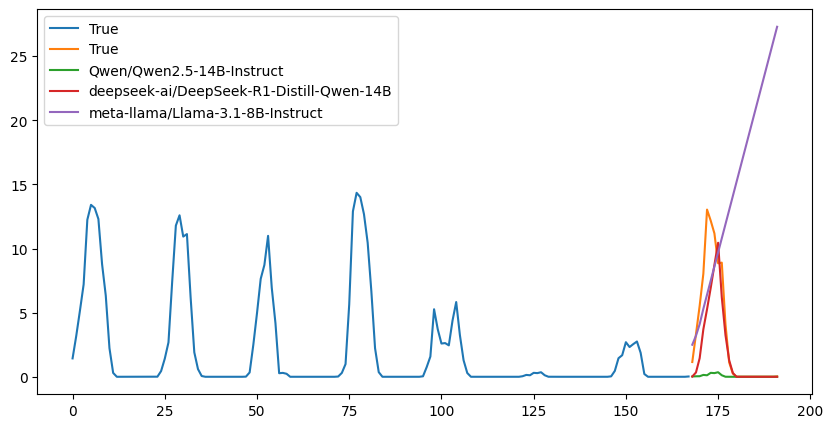

In [23]:
%matplotlib inline

plt.figure(figsize=(10, 5))

plt.plot(np.arange(len(x_ts)), x_ts, label='True')

plt.plot(np.arange(len(x_ts), len(x_ts)+len(y_ts)), y_ts, label='True')

for result in results:
    pred = result[0][:24]
    model_id = result[2]
    plt.plot(np.arange(len(x_ts), len(x_ts)+len(y_ts)), [x[1] for x in pred], label=model_id)





plt.legend()

plt.show()


In [98]:
user_prompt

'\n\nWe now have the data from The solar panel is located at Calgary Fire Hall Headquarters.. The historical data is as follows:\n\n[(20210325080000, 0.0), (20210325090000, 0.0), (20210325100000, 0.043), (20210325110000, 0.145), (20210325120000, 0.118), (20210325130000, 0.307), (20210325140000, 0.286), (20210325150000, 0.354), (20210325160000, 0.118), (20210325170000, 0.003), (20210325180000, 0.0), (20210325190000, 0.0), (20210325200000, 0.0), (20210325210000, 0.0), (20210325220000, 0.0), (20210325230000, 0.0), (20210326000000, 0.0), (20210326010000, 0.0), (20210326020000, 0.0), (20210326030000, 0.0), (20210326040000, 0.0), (20210326050000, 0.0), (20210326060000, 0.0), (20210326070000, 0.0), (20210326080000, 0.0), (20210326090000, 0.0), (20210326100000, 0.032), (20210326110000, 0.457), (20210326120000, 1.448), (20210326130000, 1.681), (20210326140000, 2.697), (20210326150000, 2.321), (20210326160000, 2.547), (20210326170000, 2.752), (20210326180000, 1.87), (20210326190000, 0.216), (202